## Analyzing Big Data with Pandas DataFrames

In [80]:
import numpy as np
import pandas as pd

In [79]:
# Packages used for interfacing w/ BigQuery from Python
from google.cloud import bigquery

# Create BigQuery client
project_id = 'polong-demo'

bq_client = bigquery.Client(project = project_id)

## Let's get some data

Data: **Wikipedia pageviews by title**, for the two days: 2022-01-01 to 2022-01-02

In [ ]:
wikidf = pd.read_csv("https://storage.googleapis.com/polong-demo-bucket/wikidf_202201.csv")

In [81]:
print(wikidf.shape)
wikidf.head(20)

(20292649, 4)


,datehour,wiki,title,views
0,2022-01-02 00:00:00 UTC,en,Being_Frank,1
1,2022-01-02 00:00:00 UTC,en,Bexhill_United_F.C.,1
2,2022-01-02 00:00:00 UTC,en,Big_Read_(Hungarian),1
3,2022-01-02 00:00:00 UTC,en,Bidar_Kadın,1
4,2022-01-02 00:00:00 UTC,en,Bill_Lickiss,1
5,2022-01-02 00:00:00 UTC,en,Belfast_North_(Assembly_constituency),1
6,2022-01-02 00:00:00 UTC,en,Battista_Fregoso,1
7,2022-01-02 00:00:00 UTC,en,"Beaufort_Castle,_Luxembourg",1
8,2022-01-02 00:00:00 UTC,en,Benjamin_Dreyer,1
9,2022-01-02 00:00:00 UTC,en,Billy_Baron,2


How **large** is this dataset in **Mb**?

In [82]:
size_wikidf = wikidf.memory_usage(index=True, deep=True).sum()
print(f"# of rows: {wikidf.shape[0]/1000000} M")
print(f"Size: {np.round(size_wikidf / 1024 / 1024, 2)} Mb")

# of rows: 20.292649 M
Size: 4368.31 Mb


## What are the top page requests by title that contain a certain word?
Let's try looking for **top page requests** based on **titles** containing a particular **regex expression**

Let's start with a sample of 100K rows

In [83]:
wikidf_100K  = wikidf.head(100000)

wikidf_100K[wikidf_100K.title.str.contains(r"[gG]oogle", na=False)]\
.groupby(['title'], as_index=False)['views'].sum()\
.sort_values('views', ascending=False)\
.head(10)

,title,views
22,Google_Docs,66
33,Google_Play,30
28,Google_Images,25
19,Google_Cast,10
18,Google_Authenticator,10
38,Google_Spaces,9
36,Google_Search_Appliance,5
34,Google_Podcasts,5
27,Google_IME,5
14,Google_Allo,5


#### How long did this take to run in Python?

In [84]:
import time

def get_top_viewed_pages(regex, df):
    start = time.time()
    result = df[df.title.str.contains(regex, na=False)]\
            .groupby(['title'], as_index=False)['views'].sum()\
            .sort_values('views', ascending=False)\
            .head(10)
    end = time.time()
    nrows = df.shape[0]
    elapsed = np.round(end-start, 3)
    print('Processing {} rows took {} s'.format(nrows, elapsed))
    #print(result.head())
    return (nrows, elapsed)

In [85]:
get_top_viewed_pages(r"[gG]oogle", wikidf_100K)

Processing 100000 rows took 0.058 s


(100000, 0.058)

#### How well does this script scale as dataframes increase in size?

In [86]:
wikidf_10000K = wikidf.head(10000000)
wikidf_1000K = wikidf.head(1000000)
wikidf_100K  = wikidf.head(100000)
wikidf_10K   = wikidf.head(10000)
wikidf_1K    = wikidf.head(1000)

In [87]:
myregex = r"[gG]oogle"

time_results = []
time_results.append(get_top_viewed_pages(myregex, wikidf_1K))
time_results.append(get_top_viewed_pages(myregex, wikidf_10K))
time_results.append(get_top_viewed_pages(myregex, wikidf_100K))
time_results.append(get_top_viewed_pages(myregex, wikidf_1000K))
time_results.append(get_top_viewed_pages(myregex, wikidf_10000K))

Processing 1000 rows took 0.008 s
Processing 10000 rows took 0.012 s
Processing 100000 rows took 0.063 s
Processing 1000000 rows took 0.625 s
Processing 10000000 rows took 6.386 s


      nrows  Seconds elapsed  log10_nrows
0      1000            0.008          3.0
1     10000            0.012          4.0
2    100000            0.063          5.0
3   1000000            0.625          6.0
4  10000000            6.386          7.0


<AxesSubplot:title={'center':'Processing time (sec.) by log(nrows) of Pandas DataFrame'}, xlabel='log10_nrows', ylabel='Seconds elapsed'>

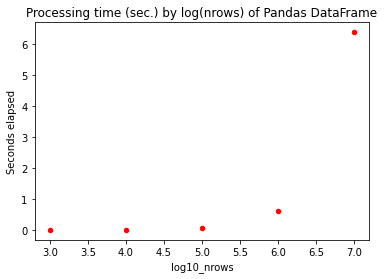

In [88]:
df_results = pd.DataFrame(time_results, columns = ["nrows","Seconds elapsed"])
df_results["log10_nrows"] = np.log10(df_results.nrows)
print(df_results)
df_results.plot(kind='scatter', 
                x='log10_nrows', y='Seconds elapsed', color='red', title="Processing time (sec.) by log(nrows) of Pandas DataFrame")

Observation: 
### As the nrow(df) increases 10x, the processing time increases exponentially

<hr>

### Let's use BigQuery

In [ ]:
%%bigquery --project {project_id} --verbose --no_query_cache
-- takes ~30s

SELECT
  COUNT(*) number_rows
FROM
  `bigquery-public-data.wikipedia.pageviews_202*`
WHERE
  datehour BETWEEN "2015-01-01" AND "2021-12-31"

In [ ]:
%%bigquery --project {project_id} --verbose --no_query_cache

SELECT
  title,
  SUM(views) totalpageviews
FROM
  `bigquery-public-data.wikipedia.pageviews_202*`
WHERE
  REGEXP_CONTAINS(title, r"[gG]oogle")
  AND datehour BETWEEN "2015-01-01" AND "2021-12-31"
GROUP BY
  title
ORDER BY
  totalpageviews DESC
LIMIT
  100